# Excercise_7 : Apply SVM to Amazon Fine Food Review Dataset

**Objective:** To apply support vector machine on Amazon Fine food Reviews dataset and to find the performance of the model.


**import the libraries**

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.metrics import recall_score,roc_auc_score,confusion_matrix,roc_curve,f1_score
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
import seaborn as sn
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from prettytable import PrettyTable

**Import the dataset**

In [0]:
f = open('x_train.pkl','rb')
x_train = pickle.load(f)
f = open('y_train.pkl','rb')
y_train = pickle.load(f)
f = open('x_test.pkl','rb')
x_test = pickle.load(f)
f = open('y_test.pkl','rb')
y_test = pickle.load(f)

FileNotFoundError: ignored

# Bag of Words

In [0]:
#Create a BOW model

bow_model = CountVectorizer()
bow_train_matrix = bow_model.fit_transform(x_train)
bow_test_matrix = bow_model.transform(x_test)
print('The length of the bag of word vectors',bow_train_matrix.shape[1])

The length of the bag of word vectors 48129


**Perform Dimensionality reduction**

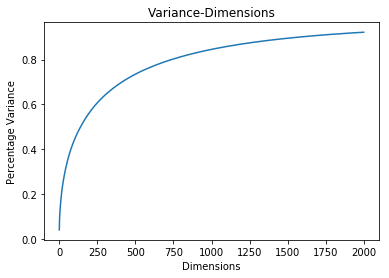

In [0]:
svd = TruncatedSVD(2000)
svd.fit(bow_train_matrix,y_train)
cdf = np.cumsum(svd.explained_variance_ratio_)
plt.plot(cdf)
plt.title('Variance-Dimensions')
plt.xlabel('Dimensions')
plt.ylabel('Percentage Variance')
plt.show()

In [0]:
#perform dimensionality reduction and standardisation using TruncatedSVD

svd = TruncatedSVD(1000)
bow_train = svd.fit_transform(bow_train_matrix)
bow_test = svd.transform(bow_test_matrix)
print('The percentage of variance explained by the dimensions',svd.explained_variance_ratio_.sum())

The percentage of variance explained by the dimensions 0.8443648265582434


In [0]:
scaler = StandardScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

**SVM - kernel - rbf**

In [0]:
#Hyperparmeter search using GridsearchCV

params = {'C' : [100,32,10,4,1,0.125,0.01,0.625,0.001,0.0001],'gamma': [100,32,10,4,1,0.125,0.01,0.625,0.001,0.0001]}
svm_model = SVC(kernel='rbf') 

grid_model = RandomizedSearchCV(svm_model,params,scoring='f1',n_jobs=-1,cv=5,verbose=10)
grid_model.fit(bow_train,y_train)

optimal_c = grid_model.best_estimator_.C
optimal_gamma = grid_model.best_estimator_.gamma

print('The optimal C is ',optimal_c)
print('The optimal gamma is',optimal_gamma)

The optimal C is  10
The optimal gamma is 0.001


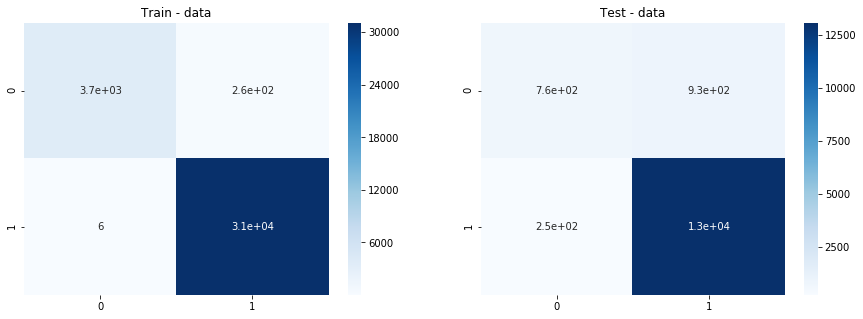

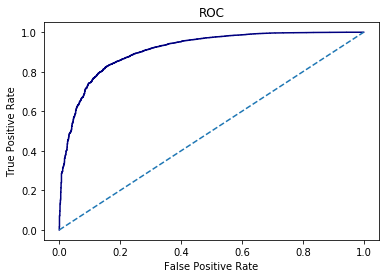

The Roc_auc score is  0.7159183265224854
The True positive rate 0.9812157186866031
The True negative rate is  0.7529644268774703
The f1_score of the model is 0.9568084404879658


In [0]:
#Prediction on test data and train data

y_pred = grid_model.predict(bow_test)
train_pred = grid_model.predict(bow_train)
prob = grid_model.decision_function(bow_test)

#plot confusion matrices and roc curve
conf = confusion_matrix(y_train,train_pred)
conf2= confusion_matrix(y_test,y_pred)
fpr,tpr,_ = roc_curve(y_test,prob)

plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Train - data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(1,2,2)
plt.title('Test - data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')
plt.figure(2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.show()

print('The Roc_auc score is ',roc_auc_score(y_test,y_pred))
print('The True positive rate',recall_score(y_test,y_pred))
print('The True negative rate is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The f1_score of the model is',f1_score(y_test,y_pred))

**SVM  - Kernel - Linear**

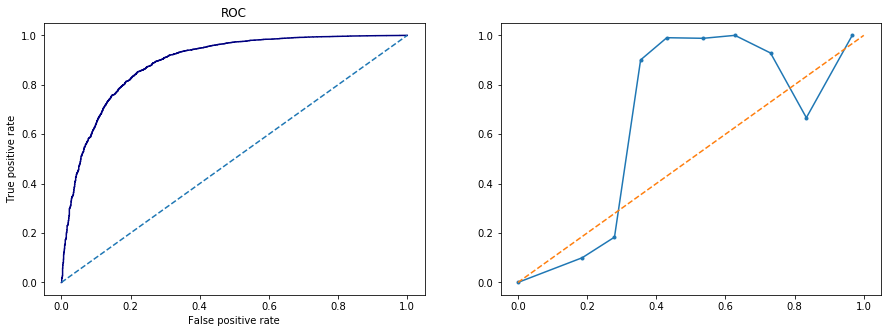

The score of the model is  0.9154666666666667
The True positive rate 0.9619806146216846
The True negative rate is  0.6473867595818815
The Roc_auc score before calibration is  0.7556798401316585


In [0]:
# fit a SGDClassifier on train data

clf = SGDClassifier(loss='hinge',n_jobs=-1) #C_svc * n_samples = 1 / alpha_sgd
clf.fit(bow_train,y_train)
score = clf.score(bow_test,y_test)
#predict on train and test data
train_pred = clf.predict(bow_train)
y_pred = clf.predict(bow_test)
conf = confusion_matrix(y_test,y_pred)

#plot calibration curves and roc curve
prob = clf.decision_function(bow_test)
fop,mpv = calibration_curve(y_test,prob,n_bins=10,normalize=True)
fpr,tpr,_ = roc_curve(y_test,prob)

plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title('ROC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.subplot(1,2,2)
plt.plot(mpv,fop,marker='.')
plt.plot([0,1],[0,1],linestyle='--')
plt.show()

print('The score of the model is ',score)
print('The True positive rate',recall_score(y_test,y_pred))
print('The True negative rate is ',conf[0][0] / (conf[0][0] + conf[1][0]))
print('The Roc_auc score before calibration is ',roc_auc_score(y_test,y_pred))


**Observations:**
1. Trained a SGDclassifier with loss-hinge and default aplha-0.0001 , C * n = 1 / alpha.
2. True negative rate is low.
3. The calibration curve shows differences in actual and predicted results.
4. The model has to be calibrated.

**Model Calibration**

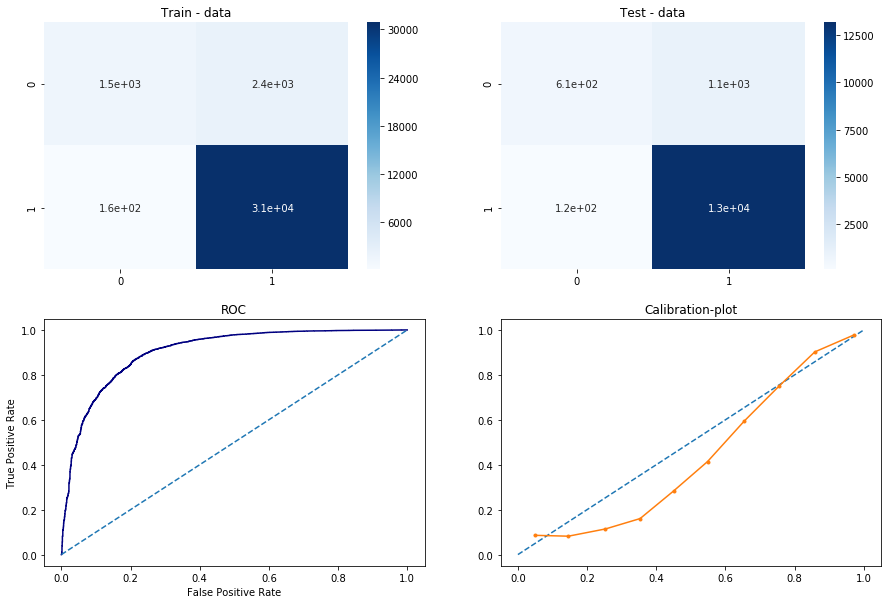

The True positive rate 0.9909084078443159
The True negative rate is  0.8353741496598639
The Roc_auc score is 0.6770035829877996


In [0]:
#calibrating the sgdclassifier

calib_model = CalibratedClassifierCV(clf,method='sigmoid',cv=10)
calib_model.fit(bow_train,y_train)

calib_pred = calib_model.predict(bow_test)
train_pred = calib_model.predict(bow_train)
test_prob = calib_model.predict_proba(bow_test)[:,1]

conf2 = confusion_matrix(y_test,calib_pred)
conf = confusion_matrix(y_train,train_pred)

fpr,tpr,thresholds = roc_curve(y_test,test_prob)
fop,mpv = calibration_curve(y_test,test_prob,n_bins=10,normalize=True)

#plot confusion matrices and roc curve
plt.figure(1,figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Train - data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(2,2,2)
plt.title('Test - data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')
plt.subplot(2,2,3)
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.subplot(2,2,4)
plt.title('Calibration-plot')
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop,marker='.')
plt.show()

print('The True positive rate',recall_score(y_test,calib_pred))
print('The True negative rate is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The Roc_auc score is',roc_auc_score(y_test,calib_pred))

**Observations:**
1. The true negative rate has increased from 64 to 83% after calibration.
2. The calibration curve is almost linear indicating good performance

 # TF-IDF

In [0]:
tfidf_model = TfidfVectorizer()
tfidf_train_matrix = tfidf_model.fit_transform(x_train)
tfidf_test_matrix = tfidf_model.transform(x_test)

**Perform Dimensionality Reduction**

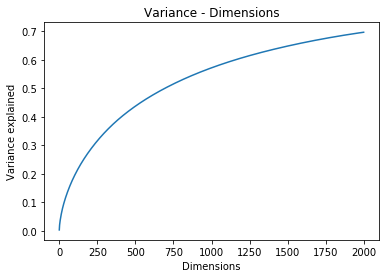

In [0]:
svd = TruncatedSVD(2000)
svd.fit(tfidf_train_matrix)
cdf = np.cumsum(svd.explained_variance_ratio_)
plt.plot(cdf)
plt.title('Variance - Dimensions')
plt.xlabel('Dimensions')
plt.ylabel('Variance explained')
plt.show()

In [0]:
#perform dimensionality reduction and standardisation using TruncatedSVD

svd = TruncatedSVD(1000)
tfidf_train = svd.fit_transform(tfidf_train_matrix)
tfidf_test = svd.transform(tfidf_test_matrix)
print('The percentage of variance explained by the dimensions',svd.explained_variance_ratio_.sum())

The percentage of variance explained by the dimensions 0.569780060331645


In [0]:
scaler = StandardScaler()
tfidf_train = scaler.fit_transform(tfidf_train)
tfidf_test = scaler.transform(tfidf_test)

**SVM - kernel - rbf**

In [0]:
params = {'C' : [100,32,10,4,1,0.125,0.01,0.625,0.001,0.0001],'gamma': [100,32,10,4,1,0.125,0.01,0.625,0.001,0.0001]}

svm_model = SVC(kernel='rbf')

grid_model = RandomizedSearchCV(svm_model,params,scoring='roc_auc',n_jobs=-1,cv=5,verbose=10)
grid_model.fit(tfidf_train,y_train)

print('The optimal c is',grid_model.best_estimator_.C)
print('The optimal gamma is ',grid_model.best_estimator_.gamma)

The optimal c is 10
The optimal gamma is  0.0001


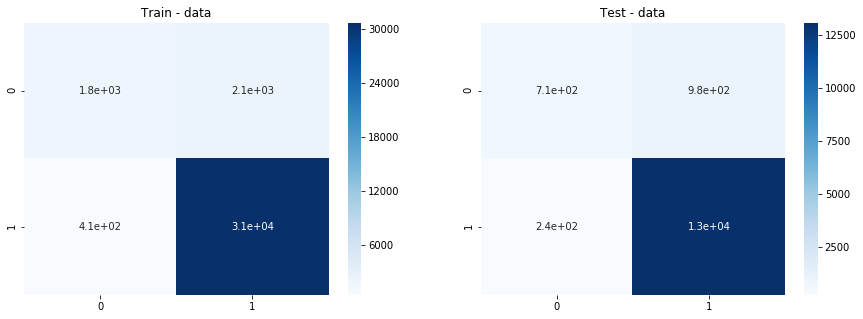

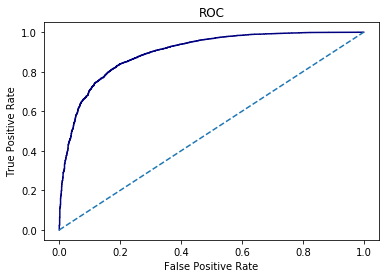

The Roc_auc score is  0.7007730859261677
The True positive rate 0.9822676384401533
The True negative rate is  0.7502645502645503
The f1_score of the model is 0.9554889636018126


In [0]:
#prediction on test and train data

y_pred = grid_model.predict(tfidf_test)
train_pred = grid_model.predict(tfidf_train)
#obtain probablities on testdata
prob = grid_model.decision_function(tfidf_test)

#plot confusion matrices and roc curve
conf = confusion_matrix(y_train,train_pred)
conf2= confusion_matrix(y_test,y_pred)
fpr,tpr,_ = roc_curve(y_test,prob)

plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Train - data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(1,2,2)
plt.title('Test - data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')
plt.figure(2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.show()

print('The Roc_auc score is ',roc_auc_score(y_test,y_pred))
print('The True positive rate',recall_score(y_test,y_pred))
print('The True negative rate is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The f1_score of the model is',f1_score(y_test,y_pred))

**SVC - kernel - linear**

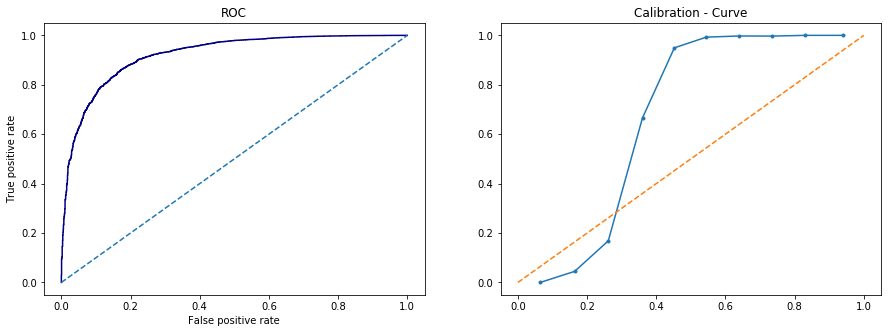

The True positive rate 0.9703959726500864
The True negative rate is  0.7048689138576779
The Roc_auc score is  0.7634357154793897
The f1_score of the model is 0.957588789204419


In [0]:
#train a sgdclassifier

clf = SGDClassifier(loss='hinge')
clf.fit(tfidf_train,y_train)
y_pred = clf.predict(tfidf_test)
train_pred = clf.predict(tfidf_train)

#plot confusion matrices
conf2 = confusion_matrix(y_test,y_pred)
#plot calibration curves
prob = clf.decision_function(tfidf_test)
fop,mpv = calibration_curve(y_test,prob,n_bins=10,normalize=True)
fpr,tpr,_ = roc_curve(y_test,prob)

plt.figure(2,figsize=(15,5))
plt.subplot(1,2,1)
plt.title('ROC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.subplot(1,2,2)
plt.title('Calibration - Curve')
plt.plot(mpv,fop,marker='.')
plt.plot([0,1],[0,1],linestyle='--')
plt.show()

print('The True positive rate',recall_score(y_test,y_pred))
print('The True negative rate is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The Roc_auc score is ',roc_auc_score(y_test,y_pred))
print('The f1_score of the model is',f1_score(y_test,y_pred))

**Model Calibration**

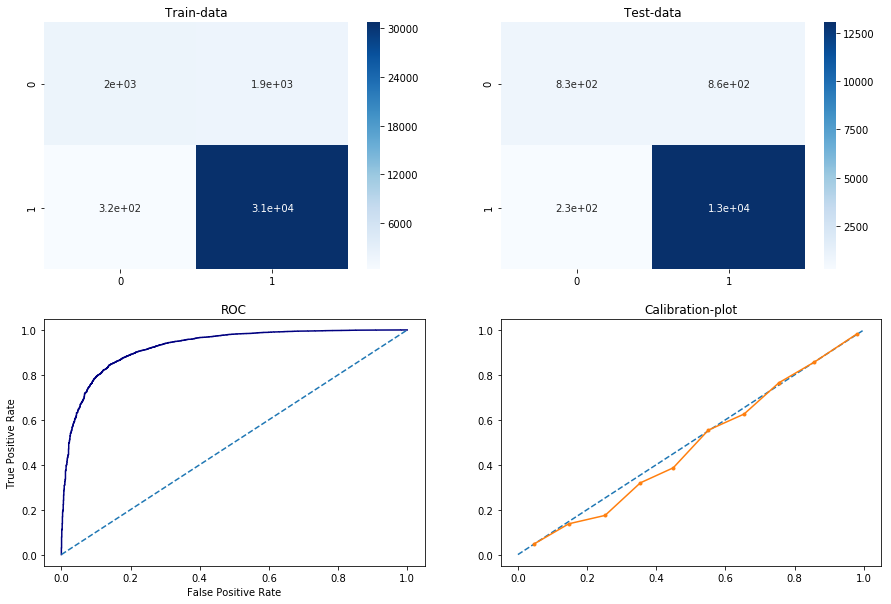

The True positive rate 0.9824179126906605
The True negative rate is  0.7796610169491526
The Roc_auc score is 0.7360345033589317


In [0]:
#calibrate the model
calib_tfidf = CalibratedClassifierCV(clf,method='sigmoid',cv=10)
calib_tfidf.fit(tfidf_train,y_train)

calib_pred = calib_tfidf.predict(tfidf_test)
train_pred = calib_tfidf.predict(tfidf_train)
test_prob = calib_tfidf.predict_proba(tfidf_test)[:,1]

conf2 = confusion_matrix(y_test,calib_pred)
conf = confusion_matrix(y_train,train_pred)

fpr,tpr,thresholds = roc_curve(y_test,test_prob)
fop,mpv = calibration_curve(y_test,test_prob,n_bins=10,normalize=True)

plt.figure(1,figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Train-data')
sn.heatmap(conf,annot=conf,cmap='Blues')

plt.subplot(2,2,2)
plt.title('Test-data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')

plt.subplot(2,2,3)
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.subplot(2,2,4)
plt.title('Calibration-plot')
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop,marker='.')
plt.show()

print('The True positive rate',recall_score(y_test,calib_pred))
print('The True negative rate is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The Roc_auc score is',roc_auc_score(y_test,calib_pred))

# Average Word2Vec

In [0]:
#create lists of lists of sentences
list_of_sent_train = []
for i in x_train.values:
  list_of_sent_train.append(i.split())
list_of_sent_test = []
for i in x_test.values:
  list_of_sent_test.append(i.split())

w2v_model = Word2Vec(list_of_sent_train,min_count=5,size=50)
w2v_words = list(w2v_model.wv.vocab)

# compute average word2vec for each review.
sent_vectors_x_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec_x_train = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_x_train += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_x_train /= cnt_words
    sent_vectors_x_train.append(sent_vec_x_train)
    
# compute average word2vec for each review.
sent_vectors_x_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec_x_test = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_x_test += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_x_test /= cnt_words
    sent_vectors_x_test.append(sent_vec_x_test)

#standardising the data

scaler = StandardScaler()
w2v_x_train = scaler.fit_transform(sent_vectors_x_train)
w2v_x_test = scaler.transform(sent_vectors_x_test)

100%|██████████| 15000/15000 [00:17<00:00, 851.88it/s]


**SVC - kernel - rbf**

In [0]:
#hyperparamter search using random search

params = {'C' : [100,32,10,4,1,0.125,0.01,0.625,0.001,0.0001],'gamma' : [100,32,10,4,1,0.125,0.01,0.625,0.001,0.0001]}
svm = SVC(kernel='rbf')
grid_model = RandomizedSearchCV(svm,params,scoring='f1',cv=5,n_jobs=-1,verbose=10)
grid_model.fit(w2v_x_train,y_train)

print('The optimal C is ',grid_model.best_estimator_.C)
print('The optimal gamma is ',grid_model.best_estimator_.gamma)

y_pred = grid_model.predict(w2v_x_test)
conf2 = confusion_matrix(y_test,y_pred)
print('The True negative rate pf the model is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The True positive rate of the model is',recall_score(y_test,y_pred))

optimal_c = grid_model.best_estimator_.C
optimal_gamma = grid_model.best_estimator_.gamma

The optimal C is  10
The optimal gamma is  0.01
The True negative rate pf the model is  0.7434620174346201
The True positive rate of the model is 0.984521752197761


The score of the model is 0.9527375845270123
The True negative rate pf the model is  0.7434620174346201
The True positive rate of the model is 0.984521752197761
The f1 score of the model is  0.9527375845270123


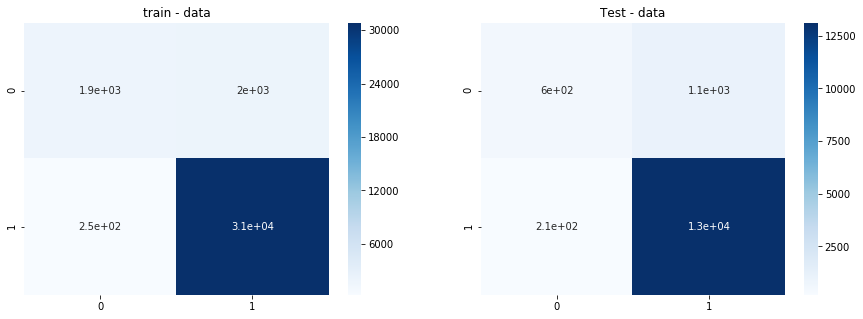

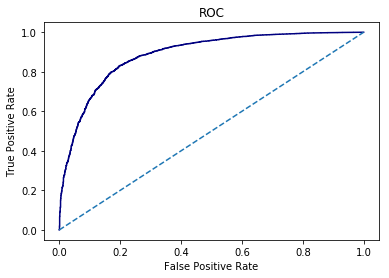

In [0]:
#train a svc model using optimal hyperparameter

svm_optimal = SVC(C=optimal_c,kernel='rbf',gamma=optimal_gamma)
svm_optimal.fit(w2v_x_train,y_train)
#prediction on test and train data
y_pred = svm_optimal.predict(w2v_x_test)
train_pred = svm_optimal.predict(w2v_x_train)
test_prob = svm_optimal.decision_function(w2v_x_test)

#plot confusion matrix
conf2 = confusion_matrix(y_test,y_pred)
conf = confusion_matrix(y_train,train_pred)
#plot roc_curve
fpr,tpr,thresholds = roc_curve(y_test,test_prob)

print('The score of the model is',grid_model.score(w2v_x_test,y_test))
print('The True negative rate pf the model is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The True positive rate of the model is',recall_score(y_test,y_pred))
print('The f1 score of the model is ',f1_score(y_test,y_pred))

#plot confusion matrices and roc curve
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title('train - data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(1,2,2)
plt.title('Test - data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')
plt.figure(2)
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

**SVM Kernel - linear**

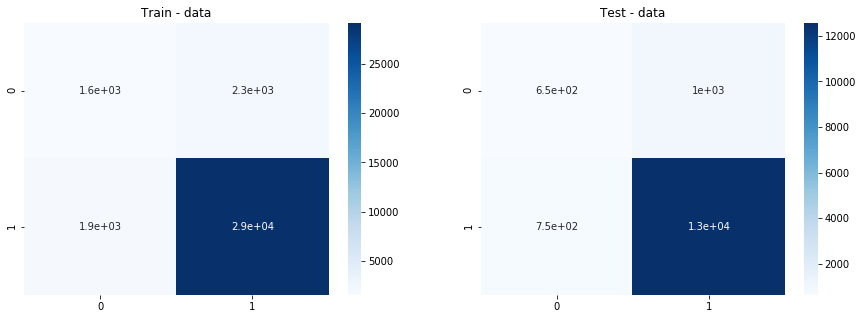

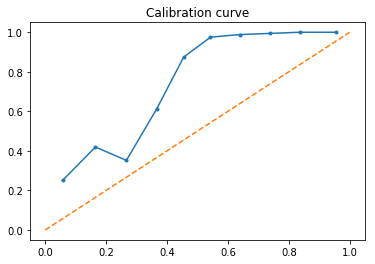

The True negative rate of the model is  0.46313528990694347
The True Positive rate  of the model is 0.9436471560598092
The f1_score of the model is 0.9333382877526754


In [0]:
#train a SGDClassifier with default alpha and hinge loss

clf = SGDClassifier(loss='hinge')
clf.fit(w2v_x_train,y_train)
#predict on train and test data
y_pred = clf.predict(w2v_x_test)
train_pred = clf.predict(w2v_x_train)

#plot confusion matrices and calibration curve
conf2 = confusion_matrix(y_test,y_pred)
conf = confusion_matrix(y_train,train_pred)

prob = clf.decision_function(w2v_x_test)

fop,mpv = calibration_curve(y_test,prob,n_bins=10,normalize=True)

plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Train - data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(1,2,2)
plt.title('Test - data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')

plt.figure(2)
plt.title('Calibration curve')
plt.plot(mpv,fop,marker='.')
plt.plot([0,1],[0,1],linestyle='--')
plt.show()
print('The True negative rate of the model is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The True Positive rate  of the model is',recall_score(y_test,y_pred))
print('The f1_score of the model is',f1_score(y_test,y_pred))

**Observations:**
1. The true negative is very low 43%.
2. The calibration curve shows bad model performance,the predicted probablities are far from the ideal result.

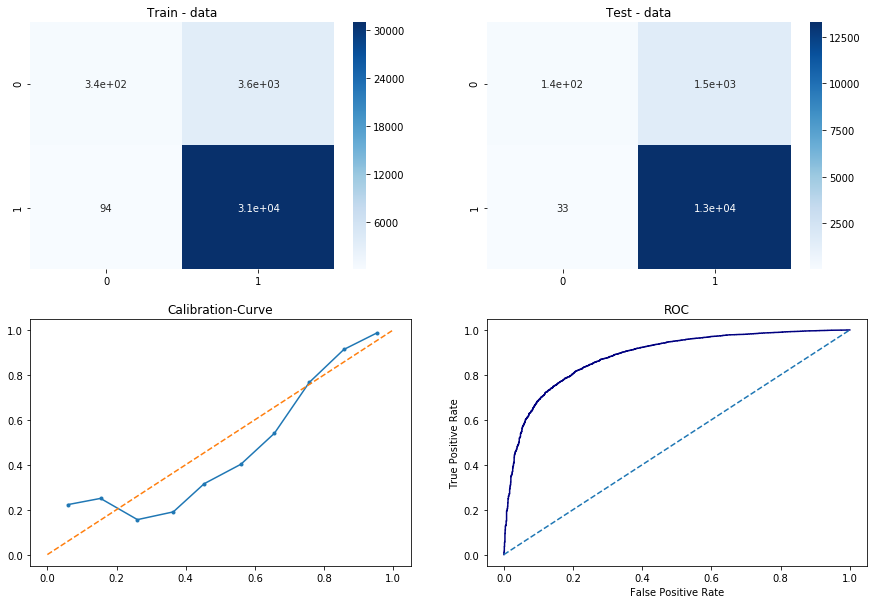

The True negative rate of the model is  0.8114285714285714
The True Positive rate  of the model is 0.9975204748666316
The f1_score of the model is 0.9437691049975119


In [0]:
#use CalibrateClassifierCV to calibrate the SGDClassifier

calib_model = CalibratedClassifierCV(clf,method='sigmoid',cv=30)
calib_model.fit(w2v_x_train,y_train)
#prediction on train and test data
y_pred = calib_model.predict(w2v_x_test)
train_pred = calib_model.predict(w2v_x_train)

conf = confusion_matrix(y_train,train_pred)
conf2 = confusion_matrix(y_test,y_pred)

#plot calibration curves
prob = calib_model.predict_proba(w2v_x_test)[:,1]
fop,mpv = calibration_curve(y_test,prob,n_bins=10,normalize=True)
fpr,tpr,_ = roc_curve(y_test,prob)
plt.figure(1,figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Train - data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(2,2,2)
plt.title('Test - data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')
plt.subplot(2,2,3)
plt.title('Calibration-Curve')
plt.plot(mpv,fop,marker='.')
plt.plot([0,1],[0,1],linestyle='--')
plt.subplot(2,2,4)
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

print('The True negative rate of the model is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The True Positive rate  of the model is',recall_score(y_test,y_pred))
print('The f1_score of the model is',f1_score(y_test,y_pred))

**Observations:**
1. The true negative rate has increased from 43% to 83%.
2. The predicted probablities graph is much closer to the ideal probablity line.

# TF-IDF weighted Word2Vec

In [0]:
#tfidf model.
tfidf_model2 = TfidfVectorizer()
tfidf_x_train = tfidf_model2.fit_transform(x_train)
idf_dict = dict(zip(tfidf_model2.get_feature_names(),list(tfidf_model2.idf_)))

# tfidfw2v vectors

tfidf_x_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]

            tf_idf = idf_dict[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_x_train_vectors.append(sent_vec)

tfidf_x_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]

            tf_idf = idf_dict[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_x_test_vectors.append(sent_vec)

#standardising the data

scaler = StandardScaler()
tfidfw2v_train = scaler.fit_transform(tfidf_x_train_vectors)
tfidfw2v_test = scaler.transform(tfidf_x_test_vectors)

100%|██████████| 15000/15000 [00:21<00:00, 708.74it/s]


**SVM - kernel - rbf**

In [0]:
#Hyperparameter search using randomizedsearchCV

svm_model = SVC(kernel='rbf')
params = {'C' : [100,32,10,4,1,0.125,0.01,0.625,0.001,0.0001],'gamma' : [100,32,10,4,1,0.125,0.01,0.625,0.001,0.0001]}
grid_model = RandomizedSearchCV(svm_model,params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=10)
grid_model.fit(tfidfw2v_train,y_train)

optimal_c = grid_model.best_estimator_.C
optimal_gamma = grid_model.best_estimator_.gamma
print('The optimal C is',optimal_c)
print('The optimal gamma is',optimal_gamma)

The optimal C is 1
The optimal gamma is 0.01


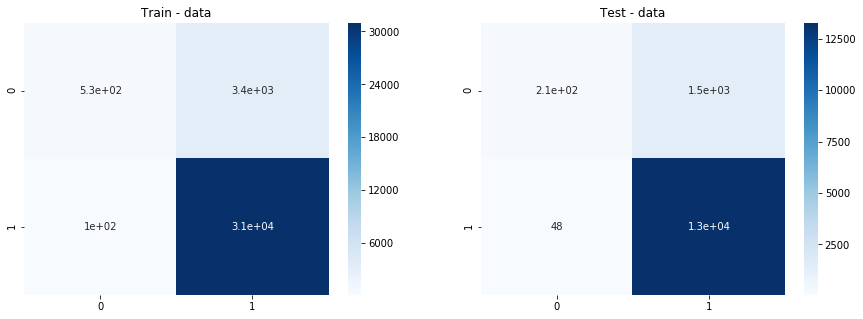

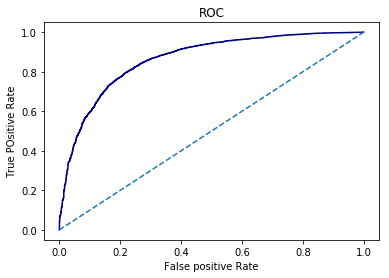

The Roc_auc score is  0.5594030957473142
The True positive rate 0.9963934179878278
The True negative rate is  0.8117647058823529
The f1_score of the model is 0.945391031581949


In [0]:
#train a svc model using the optimal hyperparameters 

svm_optimal = SVC(C = optimal_c,kernel='rbf',gamma=optimal_gamma)
svm_optimal.fit(tfidfw2v_train,y_train)

y_pred = svm_optimal.predict(tfidfw2v_test)
train_pred = svm_optimal.predict(tfidfw2v_train)

#confusion_matrix
conf2 = confusion_matrix(y_test,y_pred)
conf = confusion_matrix(y_train,train_pred)
test_prob = svm_optimal.decision_function(tfidfw2v_test)
fpr,tpr,thresholds = roc_curve(y_test,test_prob)

#plot confusion_matrix and roc_curve
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Train - data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(1,2,2)
plt.title('Test - data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')
plt.figure(2)
plt.xlabel('False positive Rate')
plt.ylabel('True POsitive Rate')
plt.title('ROC')
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.show()

print('The Roc_auc score is ',roc_auc_score(y_test,y_pred))
print('The True positive rate',recall_score(y_test,y_pred))
print('The True negative rate is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The f1_score of the model is',f1_score(y_test,y_pred))

**SVM Kernel - linear**

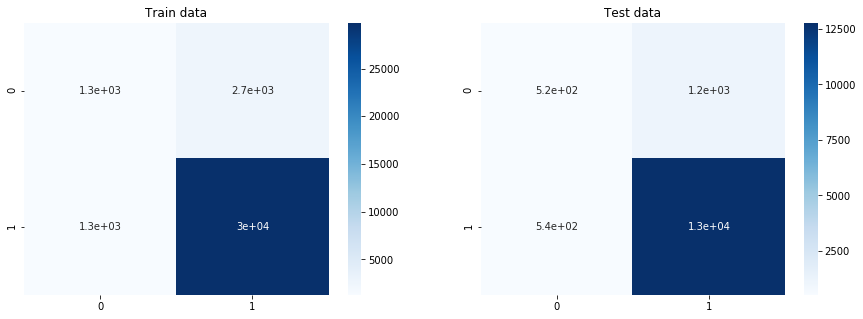

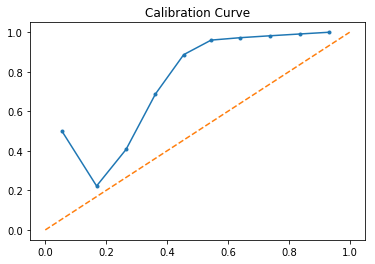

The True positive rate 0.9591254038620483
The True negative rate is  0.4976635514018692
The Roc_auc score is  0.6321351442728337
The f1_score of the model is 0.9369151161510514


In [0]:
#train a SGDClassifier with hinge loss and alpha 0.0001
clf = SGDClassifier(loss='hinge')
clf.fit(tfidfw2v_train,y_train)
y_pred = clf.predict(tfidfw2v_test)
train_pred = clf.predict(tfidfw2v_train)

#plot confusion matrices
conf2 = confusion_matrix(y_test,y_pred)
conf = confusion_matrix(y_train,train_pred)
#plot calibration curves
prob = clf.decision_function(tfidfw2v_test)
fop,mpv = calibration_curve(y_test,prob,n_bins=10,normalize=True)

plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Train data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(1,2,2)
plt.title('Test data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')

plt.figure(2)
plt.title('Calibration Curve')
plt.plot(mpv,fop,marker='.')
plt.plot([0,1],[0,1],linestyle='--')
plt.subplot(2,2,4)

plt.show()

print('The True positive rate',recall_score(y_test,y_pred))
print('The True negative rate is ',conf[0][0] / (conf[0][0] + conf[1][0]))
print('The Roc_auc score is ',roc_auc_score(y_test,y_pred))
print('The f1_score of the model is',f1_score(y_test,y_pred))

**Observations:**
1. The true negative rate is low 49%.
2. The predicted probablity line is far from the ideal line.

**Model Calibration**

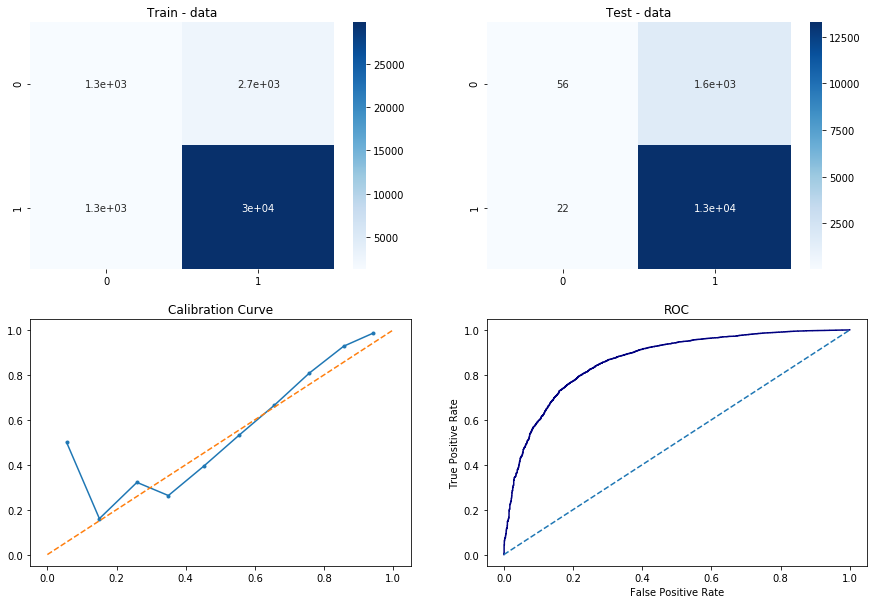

The True negative rate of the model is  0.717948717948718
The True Positive rate  of the model is 0.9983469832444211
The f1_score of the model is 0.9413056569019871


In [0]:
#calibrae the SGDClassifier using calibratedclassifier

calib_model = CalibratedClassifierCV(clf,method='isotonic',cv=50)
calib_model.fit(tfidfw2v_train,y_train)
#predict on test and train data
y_pred = calib_model.predict(tfidfw2v_test)
conf = confusion_matrix(y_train,train_pred)
conf2 = confusion_matrix(y_test,y_pred)

#plot calibration curves
prob = calib_model.predict_proba(tfidfw2v_test)[:,1]
fop,mpv = calibration_curve(y_test,prob,n_bins=10,normalize=True)
fpr,tpr,thresholds = roc_curve(y_test,test_prob)

plt.figure(1,figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Train - data')
sn.heatmap(conf,annot=conf,cmap='Blues')
plt.subplot(2,2,2)
plt.title('Test - data')
sn.heatmap(conf2,annot=conf2,cmap='Blues')
plt.subplot(2,2,3)
plt.title('Calibration Curve')
plt.plot(mpv,fop,marker='.')
plt.plot([0,1],[0,1],linestyle='--')
plt.subplot(2,2,4)
plt.plot(fpr,tpr,color='navy')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()


print('The True negative rate of the model is ',conf2[0][0] / (conf2[0][0] + conf2[1][0]))
print('The True Positive rate  of the model is',recall_score(y_test,y_pred))
print('The f1_score of the model is',f1_score(y_test,y_pred))

In [0]:
**Observations:**
1. True negative rate has increased from 49% to 71%.
2. The probablity curve of the calibrated model is much closer to the ideal line.

# Conclusion

In [0]:
x = PrettyTable()
x.field_names = ['Vectorizer','Kernel','C - optimal','gamma - optimal']
x.add_row(['BOW','rbf','10','0.001'])
x.add_row(['TF-IDF','rbf','10','0.001'])
x.add_row(['AverageW2V','rbf','10','0.01'])
x.add_row(['TF-IDF weighed W2V','rbf','1','0.01'])

print(x)

+--------------------+--------+-------------+-----------------+
|     Vectorizer     | Kernel | C - optimal | gamma - optimal |
+--------------------+--------+-------------+-----------------+
|        BOW         |  rbf   |      10     |      0.001      |
|       TF-IDF       |  rbf   |      10     |      0.001      |
|     AverageW2V     |  rbf   |      10     |       0.01      |
| TF-IDF weighed W2V |  rbf   |      1      |       0.01      |
+--------------------+--------+-------------+-----------------+
